In [1]:
#
# Copyright (C) 2023, Inria
# GRAPHDECO research group, https://team.inria.fr/graphdeco
# All rights reserved.
#
# This software is free for non-commercial, research and evaluation use 
# under the terms of the LICENSE.md file.
#
# For inquiries contact  george.drettakis@inria.fr
#

import torch
import numpy as np
from utils.general_utils import inverse_sigmoid, get_expon_lr_func, build_rotation
from torch import nn
import os
from utils.system_utils import mkdir_p
from plyfile import PlyData, PlyElement
from utils.sh_utils import RGB2SH
from simple_knn._C import distCUDA2
from utils.graphics_utils import BasicPointCloud
from utils.general_utils import strip_symmetric, build_scaling_rotation

class GaussianModel:

    def setup_functions(self):
        def build_covariance_from_scaling_rotation(scaling, scaling_modifier, rotation):
            L = build_scaling_rotation(scaling_modifier * scaling, rotation)
            actual_covariance = L @ L.transpose(1, 2)
            symm = strip_symmetric(actual_covariance)
            return symm
        
        self.scaling_activation = torch.exp
        self.scaling_inverse_activation = torch.log

        self.covariance_activation = build_covariance_from_scaling_rotation

        self.opacity_activation = torch.sigmoid
        self.inverse_opacity_activation = inverse_sigmoid

        self.rotation_activation = torch.nn.functional.normalize


    def __init__(self, sh_degree : int):
        self.active_sh_degree = 0
        self.max_sh_degree = sh_degree  
        self._xyz = torch.empty(0)
        self._features_dc = torch.empty(0)
        self._features_rest = torch.empty(0)
        self._scaling = torch.empty(0)
        self._rotation = torch.empty(0)
        self._opacity = torch.empty(0)
        self.max_radii2D = torch.empty(0)
        self.xyz_gradient_accum = torch.empty(0)
        self.denom = torch.empty(0)
        self.optimizer = None
        self.percent_dense = 0
        self.spatial_lr_scale = 0
        self.setup_functions()

    @property
    def get_scaling(self):
        return self.scaling_activation(self._scaling)
    
    @property
    def get_rotation(self):
        return self.rotation_activation(self._rotation)
    
    @property
    def get_xyz(self):
        return self._xyz
    
    @property
    def get_features(self):
        features_dc = self._features_dc
        features_rest = self._features_rest
        return torch.cat((features_dc, features_rest), dim=1)
    
    @property
    def get_opacity(self):
        return self.opacity_activation(self._opacity)
    
    def get_covariance(self, scaling_modifier = 1):
        return self.covariance_activation(self.get_scaling, scaling_modifier, self._rotation)

    def oneupSHdegree(self):
        if self.active_sh_degree < self.max_sh_degree:
            self.active_sh_degree += 1

    def construct_list_of_attributes(self):
        l = ['x', 'y', 'z', 'nx', 'ny', 'nz']
        # All channels except the 3 DC
        
        for i in range(self._features_dc.shape[1]*self._features_dc.shape[2]):
            l.append('f_dc_{}'.format(i))
        
        # l.append('red')
        # l.append('green')
        # l.append('blue')
        
        for i in range(self._features_rest.shape[1]*self._features_rest.shape[2]):
            l.append('f_rest_{}'.format(i))
        l.append('opacity')
        for i in range(self._scaling.shape[1]):
            l.append('scale_{}'.format(i))
        for i in range(self._rotation.shape[1]):
            l.append('rot_{}'.format(i))
        return l
    
    def construct_list_of_attributes_rgb(self):
        l = ['x', 'y', 'z']
        # All channels except the 3 DC
        
        for i in range(self._features_dc.shape[1]*self._features_dc.shape[2]):
            l.append('f_dc_{}'.format(i))
        
        return l

    def save_ply(self, path):
        mkdir_p(os.path.dirname(path))

        xyz = self._xyz.detach().cpu().numpy()
        normals = np.zeros_like(xyz)
        f_dc = self._features_dc.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
        f_rest = self._features_rest.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
        opacities = self._opacity.detach().cpu().numpy()
        scale = self._scaling.detach().cpu().numpy()
        rotation = self._rotation.detach().cpu().numpy()
        
        dtype_full = [(attribute, 'f4') for attribute in self.construct_list_of_attributes()]

        elements = np.empty(xyz.shape[0], dtype=dtype_full)
        attributes = np.concatenate((xyz, normals, f_dc, f_rest, opacities, scale, rotation), axis=1)
        elements[:] = list(map(tuple, attributes))
        el = PlyElement.describe(elements, 'vertex')
        PlyData([el]).write(path)
        
    def save_ply_rgb(self, path):
        mkdir_p(os.path.dirname(path))

        xyz = self._xyz.detach().cpu().numpy()
        f_dc = self._features_dc.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
        opacities = self.get_opacity.detach().cpu().numpy()
        
        scale_sum = self._scaling.sum(dim=-1)
        
        scale_max = scale_sum.max()
        scale_min = scale_sum.min()
        
        print(opacities.min(), opacities.max())
        
        
        rgb = f_dc.copy()
        for idx in range(len(opacities)):
            opacity = opacities[idx]
            rgb[idx][2] = 0
            rgb[idx][0] = opacity * 255
            # rgb[idx][1] = 255 - rgb[idx][0]
            rgb[idx][1] = 255 * (scale_sum[idx] - scale_min) / (scale_max - scale_min)

        dtype_full = [(attribute, 'f4') for attribute in self.construct_list_of_attributes_rgb()]
        for attr in ['red', 'green', 'blue']:
            dtype_full.append((attr, 'u1'))
            

        elements = np.empty(xyz.shape[0], dtype=dtype_full)
        attributes = np.concatenate((xyz, f_dc, rgb), axis=1)
        elements[:] = list(map(tuple, attributes))
        el = PlyElement.describe(elements, 'vertex')
        PlyData([el]).write(path)

    def load_ply(self, path):
        plydata = PlyData.read(path)

        xyz = np.stack((np.asarray(plydata.elements[0]["x"]),
                        np.asarray(plydata.elements[0]["y"]),
                        np.asarray(plydata.elements[0]["z"])),  axis=1)
        opacities = np.asarray(plydata.elements[0]["opacity"])[..., np.newaxis]

        features_dc = np.zeros((xyz.shape[0], 3, 1))
        features_dc[:, 0, 0] = np.asarray(plydata.elements[0]["f_dc_0"])
        features_dc[:, 1, 0] = np.asarray(plydata.elements[0]["f_dc_1"])
        features_dc[:, 2, 0] = np.asarray(plydata.elements[0]["f_dc_2"])

        extra_f_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("f_rest_")]
        extra_f_names = sorted(extra_f_names, key = lambda x: int(x.split('_')[-1]))
        assert len(extra_f_names)==3*(self.max_sh_degree + 1) ** 2 - 3
        features_extra = np.zeros((xyz.shape[0], len(extra_f_names)))
        for idx, attr_name in enumerate(extra_f_names):
            features_extra[:, idx] = np.asarray(plydata.elements[0][attr_name])
        # Reshape (P,F*SH_coeffs) to (P, F, SH_coeffs except DC)
        features_extra = features_extra.reshape((features_extra.shape[0], 3, (self.max_sh_degree + 1) ** 2 - 1))

        scale_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("scale_")]
        scale_names = sorted(scale_names, key = lambda x: int(x.split('_')[-1]))
        scales = np.zeros((xyz.shape[0], len(scale_names)))
        for idx, attr_name in enumerate(scale_names):
            scales[:, idx] = np.asarray(plydata.elements[0][attr_name])

        rot_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("rot")]
        rot_names = sorted(rot_names, key = lambda x: int(x.split('_')[-1]))
        rots = np.zeros((xyz.shape[0], len(rot_names)))
        for idx, attr_name in enumerate(rot_names):
            rots[:, idx] = np.asarray(plydata.elements[0][attr_name])

        self._xyz = nn.Parameter(torch.tensor(xyz, dtype=torch.float, device="cuda").requires_grad_(True))
        self._features_dc = nn.Parameter(torch.tensor(features_dc, dtype=torch.float, device="cuda").transpose(1, 2).contiguous().requires_grad_(True))
        self._features_rest = nn.Parameter(torch.tensor(features_extra, dtype=torch.float, device="cuda").transpose(1, 2).contiguous().requires_grad_(True))
        self._opacity = nn.Parameter(torch.tensor(opacities, dtype=torch.float, device="cuda").requires_grad_(True))
        self._scaling = nn.Parameter(torch.tensor(scales, dtype=torch.float, device="cuda").requires_grad_(True))
        self._rotation = nn.Parameter(torch.tensor(rots, dtype=torch.float, device="cuda").requires_grad_(True))

        self.active_sh_degree = self.max_sh_degree


    def prune_points(self, mask):
        valid_points_mask = ~mask
        # optimizable_tensors = self._prune_optimizer(valid_points_mask)

        self._xyz = self._xyz[valid_points_mask]
        self._features_dc = self._features_dc[valid_points_mask]
        self._features_rest = self._features_rest[valid_points_mask]
        self._opacity = self._opacity[valid_points_mask]
        self._scaling = self._scaling[valid_points_mask]
        self._rotation = self._rotation[valid_points_mask]


In [47]:
gaussian = GaussianModel(0)

dir_path = "output/11-10-22:26:36-gs-blue/point_cloud/iteration_7000"
ply_path = os.path.join(dir_path, "point_cloud.ply")

gaussian.load_ply(ply_path)
for ratio in range(1, 20):
    threshold = 1 - ratio * 0.05
    kill_mask = gaussian.get_opacity > threshold
    kill_mask = kill_mask.squeeze().cuda().bool()
    
    gaussian.prune_points(kill_mask)
    pruned_ply_path = os.path.join(dir_path, "lower_{thre:.2f}".format(thre = threshold))
    gaussian.save_ply(pruned_ply_path)
    print(threshold)
    
gaussian.load_ply(ply_path)
for ratio in range(1, 20):
    threshold = ratio * 0.05
    kill_mask = gaussian.get_opacity <= threshold
    kill_mask = kill_mask.squeeze().cuda().bool()
    
    gaussian.prune_points(kill_mask)
    pruned_ply_path = os.path.join(dir_path, "upper_{thre:.2f}".format(thre = threshold))
    gaussian.save_ply(pruned_ply_path)
    print(threshold)

0.95
0.9
0.85
0.8
0.75
0.7
0.6499999999999999
0.6
0.55
0.5
0.44999999999999996
0.3999999999999999
0.35
0.29999999999999993
0.25
0.19999999999999996
0.1499999999999999
0.09999999999999998
0.04999999999999993
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001


In [2]:
gaussian = GaussianModel(3)

dir_path = "output/11-05-21:25:51-40rock-dense/point_cloud/iteration_30000"
model_name = "point_cloud.ply"
ply_path = os.path.join(dir_path, "{}".format(model_name))

gaussian.load_ply(ply_path)

In [57]:
save_path = os.path.join(dir_path, "{}-opacity+scale.ply".format(model_name))
gaussian.save_ply_rgb(save_path)

0.0010536631 1.0


In [3]:
import open3d as o3d
import open3d_tutorial as o3dtut


pcd = o3dtut.get_eagle_pcd()
print(pcd)
o3d.visualization.draw_geometries([pcd], zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])

print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
print(mesh)
o3d.visualization.draw_geometries([mesh], zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[1.8900, 3.2596, 0.9284],
                                  up=[0.2304, -0.8825, 0.4101])

ModuleNotFoundError: No module named 'open3d_tutorial'

In [13]:
scaling = gaussian.get_scaling
max_scale = scaling.max(axis=-1).values
min_scale = scaling.min(axis=-1).values

ratio = max_scale / min_scale

tensor([0.0054, 0.0129, 0.0509,  ..., 1.2088, 0.9625, 0.5144], device='cuda:0',
       grad_fn=<MaxBackward0>)

In [20]:
min_scale

tensor([2.6928e-03, 8.9687e-04, 1.8840e-04,  ..., 8.3808e-05, 2.1962e-04,
        5.2424e-06], device='cuda:0', grad_fn=<MinBackward0>)

In [51]:
import numpy as np
log_ratio = np.log(mid_ratio.cpu().detach().numpy())
print("median:", np.median(log_ratio))
print("mean:", np.mean(log_ratio))
print("std:", np.std(log_ratio))

for q in range(1, 10):
    print("{}-th percentile:".format(int(q*10)), np.percentile(log_ratio, q=q*10))

median: 1.4054806
mean: 1.9235041
std: 1.7230551
10-th percentile: 0.2348351776599884
20-th percentile: 0.4718621850013734
30-th percentile: 0.727521526813507
40-th percentile: 1.0279159069061279
50-th percentile: 1.4054805636405945
60-th percentile: 1.879327630996704
70-th percentile: 2.4662818908691406
80-th percentile: 3.259427642822266
90-th percentile: 4.381693363189697


In [17]:
plt_ratio.shape

(669650,)

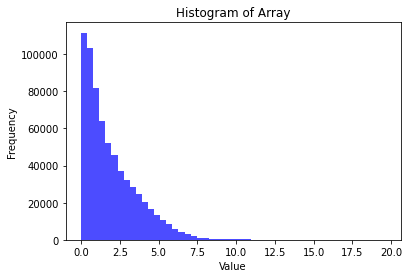

19.639776 2.3841828e-06


In [43]:
import matplotlib.pyplot as plt
import numpy as np

plt_ratio = mid_ratio.cpu().detach().numpy()
# scale_sum = torch.exp(gaussian._scaling.sum(dim=-1)).cpu().detach().numpy()
data = np.log(plt_ratio)

# Create a histogram
plt.hist(data, bins=50, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Array')

# Show the plot
plt.show()

print(data.max(), data.min())

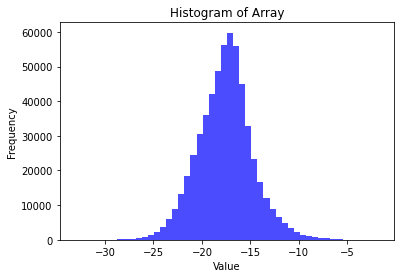

-1.693406 -33.126553


In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace this with your own array)
# data = np.random.randn(1000)

scale_sum = gaussian._scaling.cpu().detach().numpy().sum(axis=-1)
# scale_sum = torch.exp(gaussian._scaling.sum(dim=-1)).cpu().detach().numpy()
data = scale_sum

# Create a histogram
plt.hist(data, bins=50, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Array')

# Show the plot
plt.show()

print(data.max(), data.min())

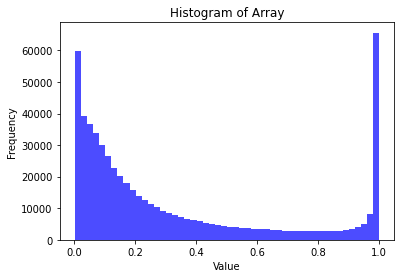

1.0 0.0010536631


In [59]:
opacity = gaussian.get_opacity.detach().cpu().numpy()
opacity = opacity.squeeze()

data = opacity

# Create a histogram
plt.hist(data, bins=50, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Array')

# Show the plot
plt.show()

print(data.max(), data.min())

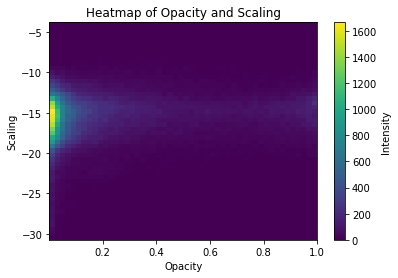

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of values for opacity and scaling
opacity = gaussian.get_opacity.detach().cpu().numpy()
opacity = opacity.squeeze()

scale_sum = gaussian._scaling.cpu().detach().numpy().sum(axis=-1) # logged
# scale_sum = torch.exp(gaussian._scaling.sum(dim=-1)).cpu().detach().numpy()

# Create a 2D array representing the heatmap data
heatmap_data = np.vstack((opacity, scale_sum))

# Create a heatmap
plt.hist2d(opacity, scale_sum, bins=50)
plt.colorbar(label='Intensity')

# Add labels and title
plt.xlabel('Opacity')
plt.ylabel('Scaling')
plt.title('Heatmap of Opacity and Scaling')

# Show the plot
plt.show()


In [72]:
heatmap_data = np.vstack((opacity, scale_sum)).transpose()

In [ ]:
from plyfile import PlyData, PlyElement

def read_ply_file(file_path):
    # Read the PLY file
    plydata = PlyData.read(file_path)

    # Extract vertices and faces from the PLY data
    vertices = np.vstack([plydata['vertex']['x'], plydata['vertex']['y'], plydata['vertex']['z']]).T

    if 'face' in plydata.elements:
        faces = plydata['face']['vertex_indices']
    else:
        faces = None

    return vertices, faces

# Example usage
ply_file_path = 'path/to/your/file.ply'  # Replace with the path to your PLY file
vertices, faces = read_ply_file(ply_file_path)

print(f"Number of vertices: {len(vertices)}")
print(f"Number of faces: {len(faces)}")


In [7]:
from mesh_to_sdf import mesh_to_voxels, sample_sdf_near_surface, mesh_to_sdf

import trimesh
import skimage

import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

mesh = trimesh.load('data/mesh/mesh_dtu40_dense_1.4.ply')

voxels = mesh_to_voxels(mesh, 64, sign_method='depth', pad=True, check_result=True)

# sample_sdf_near_surface

vertices, faces, normals, _ = skimage.measure.marching_cubes(voxels, level=0)
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)
mesh.show()

In [31]:
mesh.export("data/mesh/sdf_extracted.ply")

b'ply\nformat binary_little_endian 1.0\ncomment https://github.com/mikedh/trimesh\nelement vertex 2764\nproperty float x\nproperty float y\nproperty float z\nproperty float nx\nproperty float ny\nproperty float nz\nelement face 5524\nproperty list uchar int vertex_indices\nend_header\n\xe8\x01\x12B\x00\x00\x10B\x00\x00\xa0Ad\x9cZ?r/\x05?L\x96(\xbc\x00\x00\x14B2w\x0eB\x00\x00\xa0AD\x07\xe6>T\xaba?g\xa7\x14>\x00\x00\x14B\x00\x00\x10B\x05\xb5\x9aA\xc8|\xd4>\xe5$@?\xaa\xa3\x03?\x00\x00\x14B\x00\x00\x10BD\xfd\xa6A\xe7&\xe4>d\xbcF?\xecD\xe4\xbe\xcaL\x12B\x00\x00\x14B\x00\x00\x88Ap}e?S,\xb6>\xabA\x87>\x00\x00\x14B\xddb\x12B\x00\x00\x88A\x94\xa6\x93>\xae\x8fa?\x82\xea\xbf>\x00\x00\x14B\x00\x00\x14B\x99x\x80A\xf6\xfe\x03?\xe5M=?Z\x9a\xdd>\xd6u\x11B\x00\x00\x14B\x00\x00\x90A\xfa9w?\x9bBe>*w\x06>\x00\x00\x14B\'\xa8\x10B\x00\x00\x90A\x1c\x13\xea>\xaf\xf7[?\xaa\x08k>}\x01\x11B\x00\x00\x14B\x00\x00\x98Ak`}?8\xe7\x0f>\x92s\xcf<\x00\x00\x14B\x8e\xc3\x10B\x00\x00\x98A\x06\'\xe2>\xa0\x00d?.8\xdd=:\x0b\x

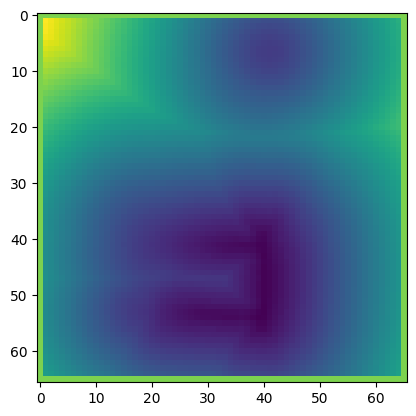

In [30]:
import matplotlib.pyplot as plt
plt.imshow(voxels[:,:,p])

# mesh.save

In [29]:
p = 16
print(voxels[:,:,p])
print(voxels[:,:,p].min())
print(voxels[:,:,p].max())

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.2690903  1.238588   ... 0.72389716 0.75416577 1.        ]
 [1.         1.2631816  1.2325988  ... 0.7171316  0.7476741  1.        ]
 ...
 [1.         0.6344674  0.60815215 ... 0.63543093 0.6651532  1.        ]
 [1.         0.65109    0.6254745  ... 0.6436593  0.6730183  1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
-0.106294625
1.2690903
